In [1]:
%load_ext autoreload
%autoreload 2

# Burger's 1D equation

Benchmark on the Burger 1D as proposed in the PINNacle benchmark paper (https://arxiv.org/pdf/2306.08827) (see Appendix B1: (**Burgers1d**)).

We dig through the PINNacle code database to retrieve the experimental setting (number of collocation points, number of iterations, ...) as well as the reference values of the solution.
While PINNacle codes use a callback for evaluating the error with respect to the reference, we simply make a pridction at the end of the training (see [here](https://github.com/i207M/PINNacle/blob/main/src/utils/callbacks.py#L104))

In [2]:
import numpy as np

# from PINNACLE
DEFAULT_NUM_DOMAIN_POINTS = 8192
DEFAULT_NUM_BOUNDARY_POINTS = 2048
DEFAULT_NUM_INITIAL_POINTS = 2048

ref_data = np.loadtxt("burgers1d.dat", comments="%").astype(np.float32)

## DeepXDE


We use the JAX backend.

In [22]:
seed = 1

Using backend: jax
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



Compiling model...


2024-11-26 15:31:55.401565: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.3.107. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


'compile' took 1.593591 s

Training model...

Traced<ShapedArray(float32[16384,1])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[16384,1])>with<DynamicJaxprTrace(level=1/0)>
Step      Train loss                        Test loss                         Test metric
0         [1.07e-02, 7.59e-02, 3.40e-01]    [1.07e-02, 7.59e-02, 3.40e-01]    []  
1000      [2.45e-02, 4.19e-04, 2.06e-02]    [2.45e-02, 4.19e-04, 2.06e-02]    []  
2000      [1.42e-03, 4.02e-06, 1.07e-03]    [1.42e-03, 4.02e-06, 1.07e-03]    []  
3000      [1.91e-03, 8.62e-05, 6.35e-04]    [1.91e-03, 8.62e-05, 6.35e-04]    []  
4000      [1.20e-02, 2.28e-04, 1.97e-04]    [1.20e-02, 2.28e-04, 1.97e-04]    []  
5000      [1.74e-04, 1.87e-05, 5.12e-05]    [1.74e-04, 1.87e-05, 5.12e-05]    []  
6000      [2.16e-03, 8.04e-05, 7.18e-05]    [2.16e-03, 8.04e-05, 7.18e-05]    []  
7000      [1.25e-03, 4.14e-05, 1.07e-04]    [1.25e-03, 4.14e-05, 1.07e-04]    []  
8000      [1.67e-03, 2.16e-04, 2.28e-04]    [1.67e-03, 2

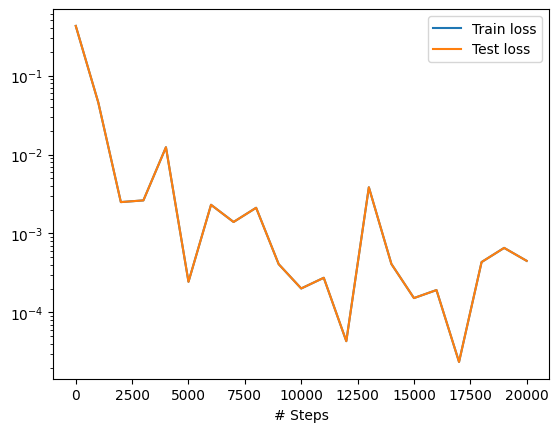

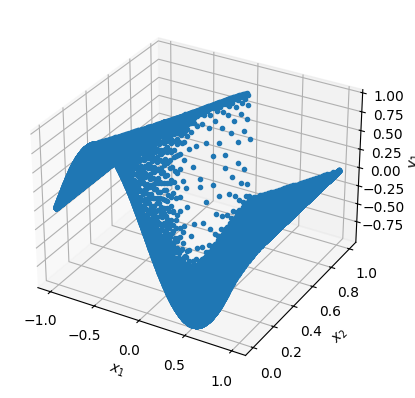

In [4]:
import os
os.environ["DDE_BACKEND"]="jax"
import deepxde as dde

# Determinism may reduce performance in DeepXDE (see doc) but needs to
# be set for a fair comparison with Jinns
# https://deepxde.readthedocs.io/en/stable/modules/deepxde.html#deepxde.config.set_random_seed
dde.config.set_random_seed(seed)


def pde(x, y):
    y_val, y_fn = y
    print(y_val)
    dy_x, _ = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t, _ = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx, _ = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y_val * dy_x - 0.01 / np.pi * dy_xx


geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial
)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=DEFAULT_NUM_DOMAIN_POINTS,
    num_boundary=DEFAULT_NUM_BOUNDARY_POINTS,
    num_initial=DEFAULT_NUM_INITIAL_POINTS,
    # train_distribution="uniform" # this is the default
    # num_test=None # this is the Default, we perform a evaluation callback on the same dataset as the training (see the test column in the training log)
)
net = dde.nn.FNN([2] + [100] * 5 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=20000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

## With Jinns

In [23]:
import jax
import equinox as eqx
import jinns
import jax.numpy as jnp
from jax import grad, vmap, random
import optax
import time
import matplotlib.pyplot as plt

key = random.PRNGKey(seed)

In [24]:
eqx_list = (
    (eqx.nn.Linear, 2, 100),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 100, 100),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 100, 100),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 100, 100),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 100, 100),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 100, 1)
)
key, subkey = random.split(key)
u_pinn, init_nn_params_pinn = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 1)

In [25]:
n = DEFAULT_NUM_DOMAIN_POINTS
ni = DEFAULT_NUM_INITIAL_POINTS
nb = DEFAULT_NUM_BOUNDARY_POINTS
dim = 1
xmin = -1
xmax = 1
tmin = 0
tmax = 1
Tmax = 1
method = "grid" # equals "uniform" in deepXDE, while "uniform" in jinns equals "pseudo" in deepXDE

train_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    ni=ni,
    dim=dim,
    min_pts=(xmin,),
    max_pts=(xmax,),
    tmin=tmin,
    tmax=tmax,
    method=method,
)

In [26]:
# create Burger loss
nu = 1 / (100 * jnp.pi)


In [27]:
# Init parameters for NN and equation
init_params_pinn = jinns.parameters.Params(
    nn_params=init_nn_params_pinn,
    eq_params={
        "nu":nu
    }
)

In [28]:
from jinns.loss import PDENonStatio

class BurgerEquation(PDENonStatio):
    def equation(self, t_x, u, params):
        u_ = lambda t_x: jnp.squeeze(u(t_x, params))
        du_dtx = jax.grad(u_)
        d2u_dx_dtx = jax.grad(lambda t_x: du_dtx(t_x)[1])
        du_dtx_values = du_dtx(t_x)

        return du_dtx_values[0:1] + self.Tmax * (
            u_(t_x) * du_dtx_values[1:2]
            - params.eq_params["nu"] * d2u_dx_dtx(t_x)[1:2]
        )

be_loss = BurgerEquation(Tmax=Tmax)

In [29]:
def u0(x):
    return -jnp.sin(jnp.pi * x)

loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1, initial_condition=1, boundary_loss=1
)

loss_pinn = jinns.loss.LossPDENonStatio(
    u=u_pinn,
    loss_weights=loss_weights,
    dynamic_loss=be_loss,
    omega_boundary_fun=lambda t_dx: 0,
    omega_boundary_condition="dirichlet",
    initial_condition_fun=u0,
    params=init_params_pinn,
)

In [30]:
# Training loop in Jinns
params_pinn = init_params_pinn
tx = optax.adam(learning_rate=1e-3)
n_iter = 20000

In [31]:
params_pinn, total_loss_list_pinn, loss_by_term_dict_pinn, _, _, _, _ , _, _ = jinns.solve(
    init_params=params_pinn,
    data=train_data,
    optimizer=tx,
    loss=loss_pinn,
    n_iter=n_iter,
    verbose=True
)


Compilation took
 2.233574390411377 

[train] Iteration 0: loss value = 0.4991694688796997
[train] Iteration 1000: loss value = 0.08169522881507874
[train] Iteration 2000: loss value = 0.012765016406774521
[train] Iteration 3000: loss value = 0.0095940250903368
[train] Iteration 4000: loss value = 0.008517595008015633
[train] Iteration 5000: loss value = 0.0021916795521974564
[train] Iteration 6000: loss value = 0.001125513343140483
[train] Iteration 7000: loss value = 0.0012298936489969492
[train] Iteration 8000: loss value = 0.000504695693962276
[train] Iteration 9000: loss value = 0.0001400342007400468
[train] Iteration 10000: loss value = 0.0015220348723232746
[train] Iteration 11000: loss value = 0.0003649475984275341
[train] Iteration 12000: loss value = 0.0002902531996369362
[train] Iteration 13000: loss value = 0.0005469028255902231
[train] Iteration 14000: loss value = 0.00019422922923695296
[train] Iteration 15000: loss value = 7.142945833038539e-05
[train] Iteration 16000: 

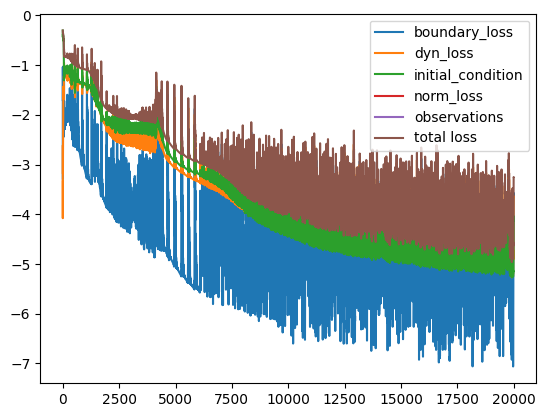

In [32]:
for loss_name, loss_values in loss_by_term_dict_pinn.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list_pinn), label="total loss")
plt.legend()
plt.show()

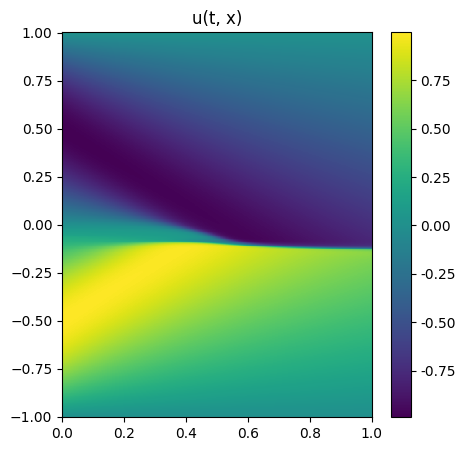

In [33]:
nx = 500
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 500
val_times = jnp.linspace(tmin, tmax, ntime)

u_est_pinn = lambda t_x:u_pinn(t_x, params_pinn)
# same subkey
jinns.plot.plot1d_image(u_est_pinn, xdata=val_xdata, times=val_times, cmap="viridis", colorbar=True, figsize=(5, 5), title="u(t, x)")

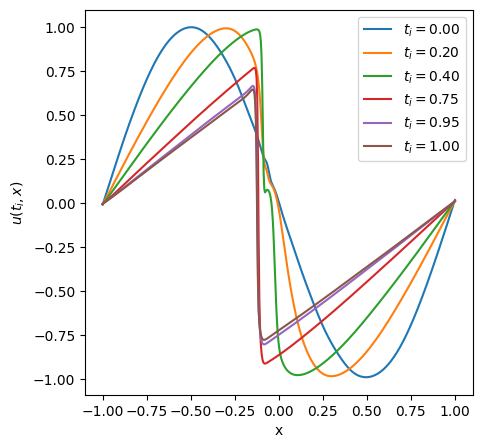

In [34]:
time_slices = [0, 0.2, 0.4, 0.75, 0.95, 1.]
jinns.plot.plot1d_slice(u_est_pinn, xdata=val_xdata, time_slices=time_slices,  figsize=(5, 5))

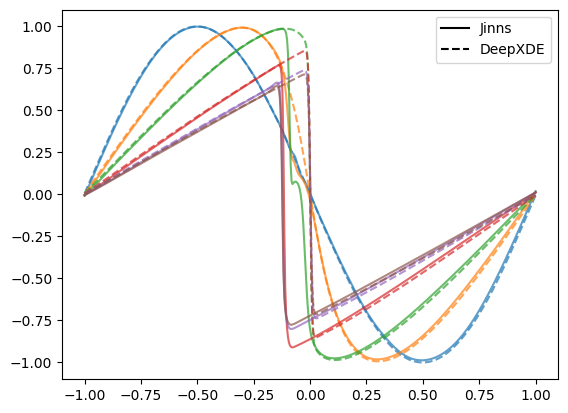

In [35]:
from functools import partial

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
diffs = []
for i, ti in enumerate(time_slices):
    val_ti = jnp.column_stack([val_xdata, jnp.repeat(ti, nx)])
    val_ti_normalized = jnp.column_stack([jnp.repeat(ti, nx) / Tmax, val_xdata, ])
    u_est_tfixed = vmap(u_est_pinn)#vmap(partial(u_est_pinn, t=ti * jnp.ones((1,)) / Tmax), 0, 0)
    plt.plot(val_xdata, model.predict(x=val_ti), label=rf"$DDE: t_i = {ti}$", linestyle="--", alpha=.7, color = cycle[i])
    plt.plot(val_xdata, u_est_tfixed(val_ti_normalized), label=rf"$Jinns:  t_i = {ti}$", alpha=.7, color = cycle[i])
    diffs.append(jnp.abs(u_est_tfixed(val_ti_normalized) - model.predict(x=val_ti)))

    # plt.plot(val_xdata, u_est_tfixed(x=val_xdata[:, None]), label=rf"$Jinns:  t_i = {ti}$", alpha=.7, color = cycle[i])
    # diffs.append(jnp.abs(u_est_tfixed(x=val_xdata[:, None]) - model.predict(x=val_ti)))

from matplotlib.lines import Line2D
line_jinns = Line2D([0], [0], label='Jinns', color='black',linestyle="-")
line_dde = Line2D([0], [0], label='DeepXDE', color='black', linestyle="--")
plt.legend(handles=[line_jinns, line_dde])

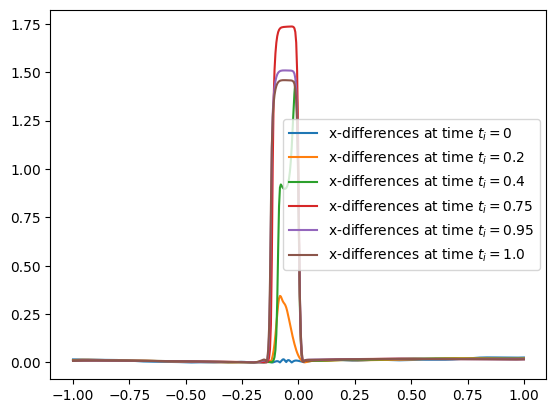

In [36]:
for dif, ti in zip(diffs, time_slices):
    plt.plot(val_xdata, dif, label=rf"x-differences at time $t_i={ti}$")
plt.legend()

## Comparisons

In [37]:
import sys
sys.path.append('../')

from PINNacle_utils import trans_time_data_to_dataset, compute_relative_errors

ref_data_ = trans_time_data_to_dataset(ref_data, "burgers1d.dat", 2, 1)

nan_mask = np.isnan(ref_data_).any(axis=1)
test_x = ref_data_[~nan_mask, :2]
test_y = ref_data_[~nan_mask, 2:]


In [38]:
compute_relative_errors(test_y, model.predict(test_x))

l1re=0.012193580037484643, l2re=0.02148657553995477


In [39]:
# /!\ t and x must be inverted in jinns convention
test_x_j = np.copy(test_x)
test_x_j[:, 0] = test_x[:, 1]
test_x_j[:, 1] = test_x[:, 0]

compute_relative_errors(test_y, jax.vmap(u_est_pinn)(test_x_j))

l1re=0.13088061278626884, l2re=0.5474868245814847
